# Wildland Fire Data Analysis on Healthcare Impact

The goal of this notebook is to examine the health impact of wildfires on Indianapolis, IN. More specically, we will be assessing the impact of wildre smoke on respiratory health.

## License

The code lies under the standard [MIT licence](./LICENSE).

## Setup

In [48]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse

from tqdm import tqdm
import warnings

In [ ]:
#########
#
#    CONSTANTS
#
FIRE_ANNUAL_SMOKE_ESTIMATES_PATH = "final/fire_annual_smoke_estimates.csv"
HEALTHCARE_COMBINED_DATA_PATH = 'intermediate/healthcare_combined_data.csv'

## Exploratory Data Analysis

In [ ]:
fire_annual_smoke_estimates_df = pd.read_csv(FIRE_ANNUAL_SMOKE_ESTIMATES_PATH)

In [4]:
healthcare_combined_df = pd.read_csv(HEALTHCARE_COMBINED_DATA_PATH)

### State Analysis
First we check the trends of smoke estimates around Indiana, with those of respiratory illnesses in Indiana state.

#### Analysis 1
Check the correlation between incidence of the respiratory illnesses and smoke estimates in Indiana

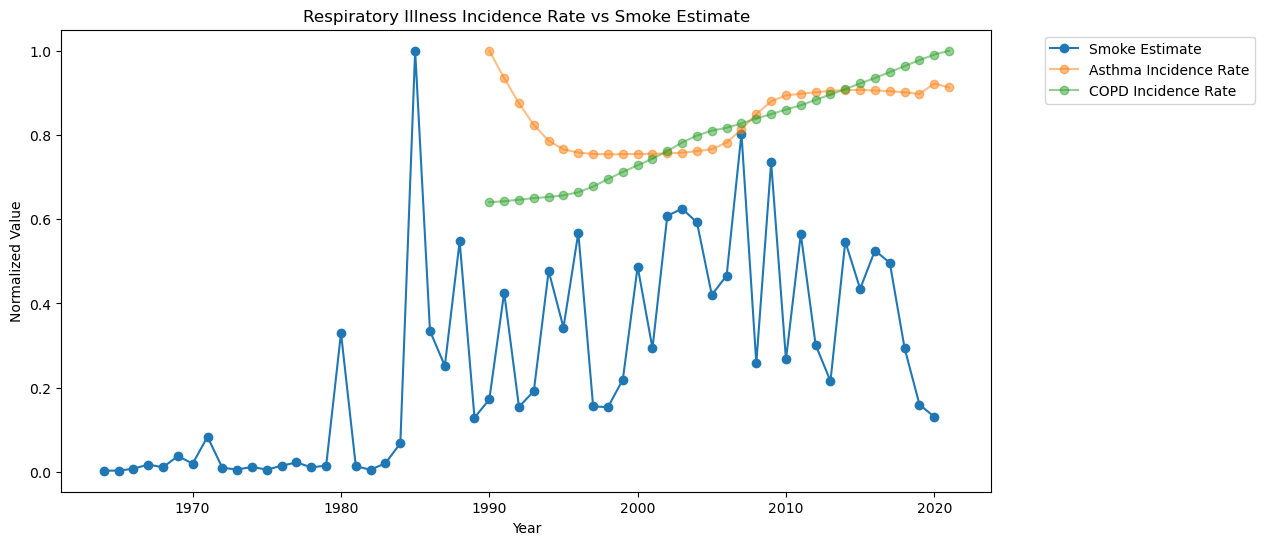

In [6]:
# Check the trend of smoke estimates and RI incidence rate
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot asthma incidence rate
healthcare_asthma_incidence_df = healthcare_combined_df[['Year', 'Asthma_Incidence_Rate_State']].dropna()
plt.plot(healthcare_asthma_incidence_df['Year'], 
         healthcare_asthma_incidence_df['Asthma_Incidence_Rate_State']/max(healthcare_asthma_incidence_df['Asthma_Incidence_Rate_State']), 
         marker='o', alpha=0.5)
# Plot COPD incidence rate
healthcare_copd_incidence_df = healthcare_combined_df[['Year', 'COPD_Incidence_Rate_State']].dropna()
plt.plot(healthcare_copd_incidence_df['Year'], 
         healthcare_copd_incidence_df['COPD_Incidence_Rate_State']/max(healthcare_copd_incidence_df['COPD_Incidence_Rate_State']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Respiratory Illness Incidence Rate vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Asthma Incidence Rate', 'COPD Incidence Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

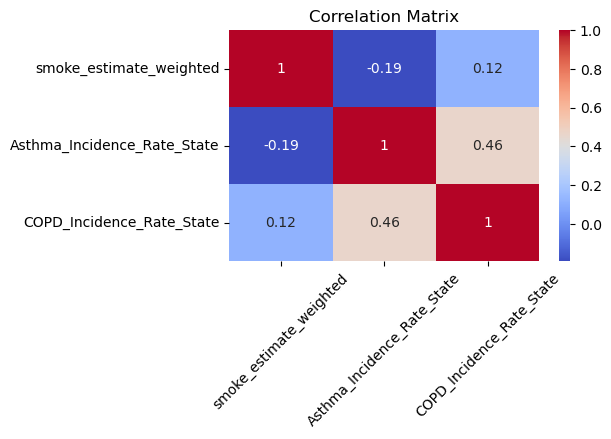

In [17]:
# Check Pearson correlation between smoke estimates and RI incidence rate
# Merge the dataframes
smoke_ri_incidence_combined_df = pd.merge(fire_annual_smoke_estimates_df, healthcare_combined_df, left_on='Fire_Year', right_on='Year', how='inner')
# Calculate correlation
correlation = smoke_ri_incidence_combined_df[['smoke_estimate_weighted', 'Asthma_Incidence_Rate_State', 'COPD_Incidence_Rate_State']].corr()
# Plot the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

As one can see, the trends and the correlation matrix do not show significant correlation between the calculated smoke estimates and respiratory illness incidence rates in Indiana.

#### Analysis 2
Check the correlation between deaths by the respiratory illnesses and smoke estimates in Indiana

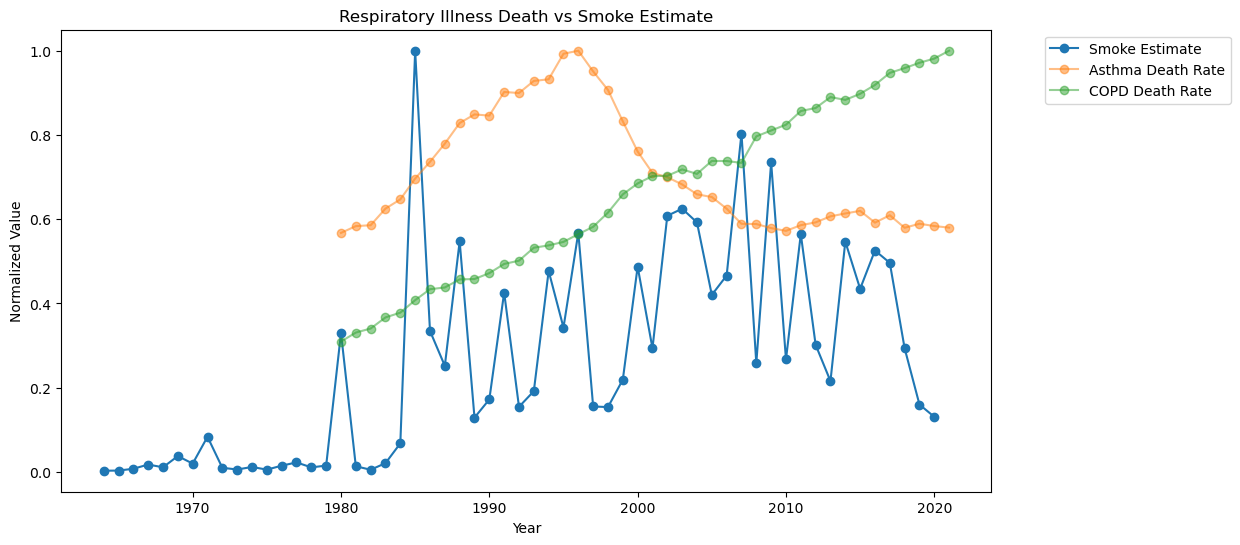

In [7]:
# Check the trend of smoke estimates and RI death rate
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot asthma incidence rate
healthcare_asthma_death_df = healthcare_combined_df[['Year', 'Asthma_Death_Rate_State']].dropna()
plt.plot(healthcare_asthma_death_df['Year'], 
         healthcare_asthma_death_df['Asthma_Death_Rate_State']/max(healthcare_asthma_death_df['Asthma_Death_Rate_State']), 
         marker='o', alpha=0.5)
# Plot COPD incidence rate
healthcare_copd_death_df = healthcare_combined_df[['Year', 'COPD_Death_Rate_State']].dropna()
plt.plot(healthcare_copd_death_df['Year'], 
         healthcare_copd_death_df['COPD_Death_Rate_State']/max(healthcare_copd_death_df['COPD_Death_Rate_State']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Respiratory Illness Death vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Asthma Death Rate', 'COPD Death Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

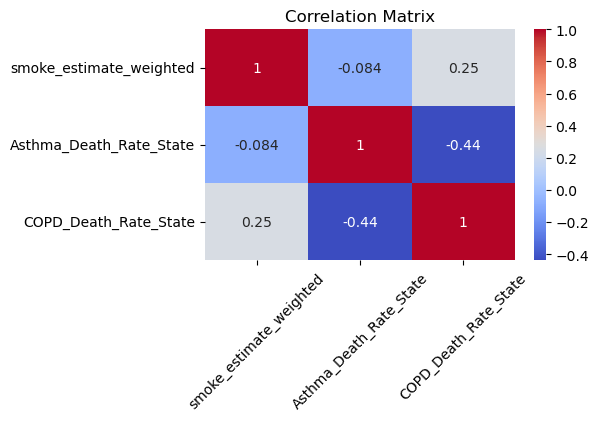

In [18]:
# Check Pearson correlation between smoke estimates and RI death rate
# Merge the dataframes
smoke_ri_death_combined_df = pd.merge(fire_annual_smoke_estimates_df, healthcare_combined_df, left_on='Fire_Year', right_on='Year', how='inner')
# Calculate correlation
correlation = smoke_ri_death_combined_df[['smoke_estimate_weighted', 'Asthma_Death_Rate_State', 'COPD_Death_Rate_State']].corr()
# Plot the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

Again, the trends and correlation matrix do not show significant correlation between the calculated smoke estimates and respiratory illness death rates.

Smoke estimates and COPD death rate do seem to have a non-negligible positive correlation. It is of course, hard to infer causation from these trends and the correlation matrix.
One may see the slightly upward trend of smoke estimates as an indication of correlation, although the fluctuations in smoke estimates are too large to give a definitive answer.\
A definitive answer would require an extensive causal analysis that accounts for any signiciant confounding variables. 

#### Analysis 3
Check the correlation between deaths per 100 incidences by the respiratory illnesses and smoke estimates, to see if there is any correlation to fatality rate of respiratory illnesses and smoke

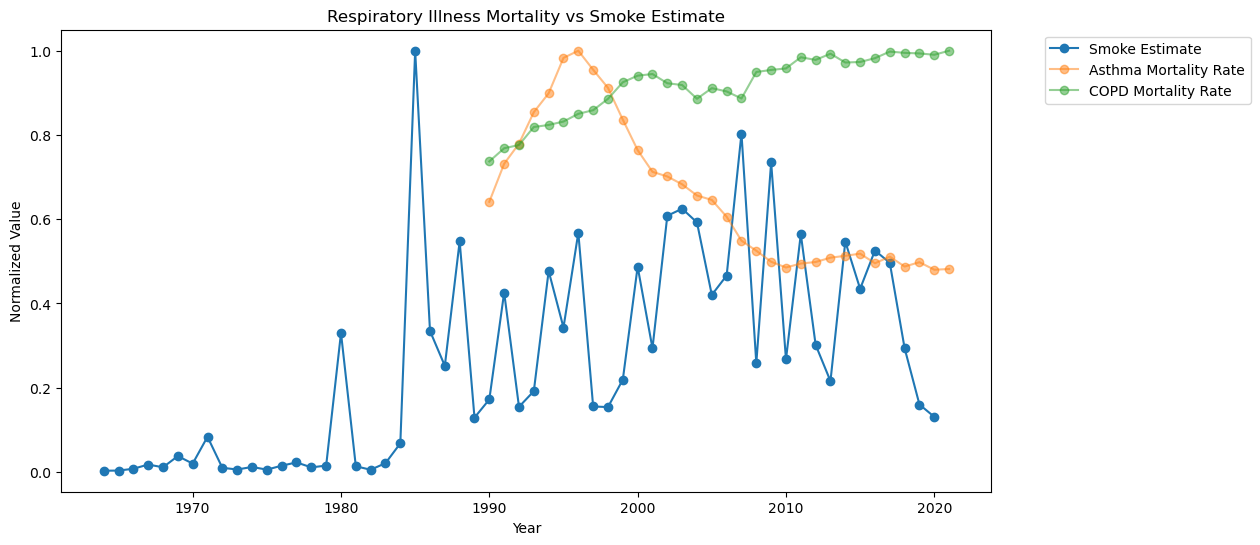

In [20]:
# Check the trend of smoke estimates and RI mortality rate
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot asthma incidence rate
healthcare_asthma_mortality_df = healthcare_combined_df[['Year', 'Asthma_Death_Rate_State', 'Asthma_Incidence_Rate_State']].dropna()
healthcare_asthma_mortality_df['Asthma_Mortality_Rate_State'] = healthcare_asthma_mortality_df['Asthma_Death_Rate_State']\
    /healthcare_asthma_mortality_df['Asthma_Incidence_Rate_State']*100
plt.plot(healthcare_asthma_mortality_df['Year'], 
         healthcare_asthma_mortality_df['Asthma_Mortality_Rate_State']/max(healthcare_asthma_mortality_df['Asthma_Mortality_Rate_State']), 
         marker='o', alpha=0.5)
# Plot COPD incidence rate
healthcare_copd_mortality_df = healthcare_combined_df[['Year', 'COPD_Death_Rate_State', 'COPD_Incidence_Rate_State']].dropna()
healthcare_copd_mortality_df['COPD_Mortality_Rate_State'] = healthcare_copd_mortality_df['COPD_Death_Rate_State']\
    /healthcare_copd_mortality_df['COPD_Incidence_Rate_State']*100
plt.plot(healthcare_copd_mortality_df['Year'], 
         healthcare_copd_mortality_df['COPD_Mortality_Rate_State']/max(healthcare_copd_mortality_df['COPD_Mortality_Rate_State']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Respiratory Illness Mortality vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Asthma Mortality Rate', 'COPD Mortality Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Analysis 4
Check the correlation between premature deaths (by any cause) in Indiana and smoke estimates

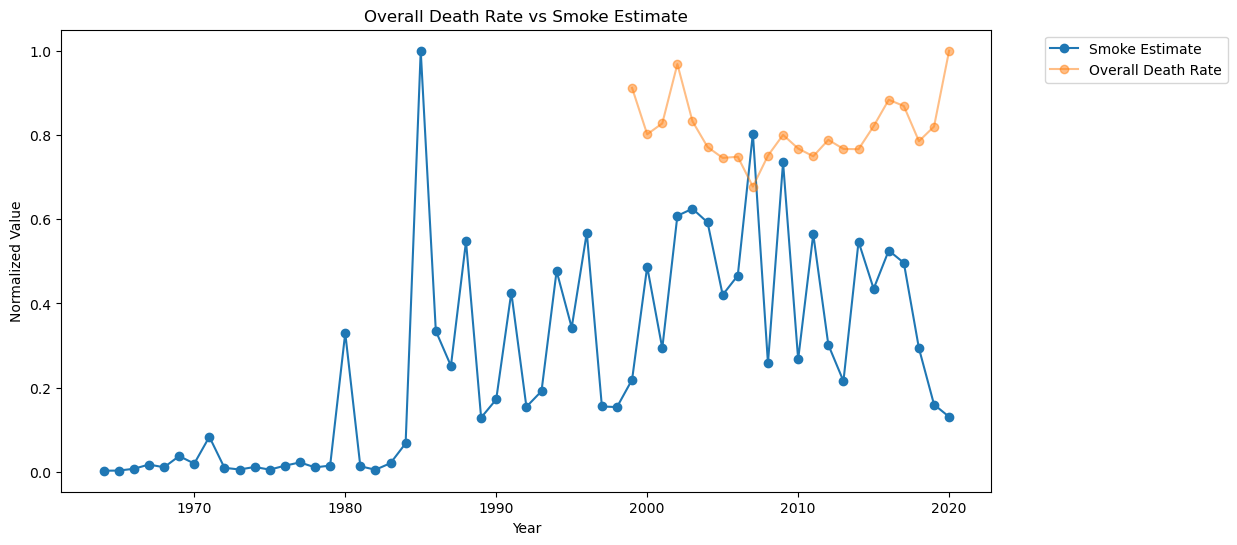

In [11]:
# Check the trend of smoke estimates and overall death rate in Indiana
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot overall death rate
healthcare_death_rate_df = healthcare_combined_df[['Year', 'Death_Rate_State']].dropna()
plt.plot(healthcare_death_rate_df['Year'], 
         healthcare_death_rate_df['Death_Rate_State']/max(healthcare_death_rate_df['Death_Rate_State']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Overall Death Rate vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Overall Death Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

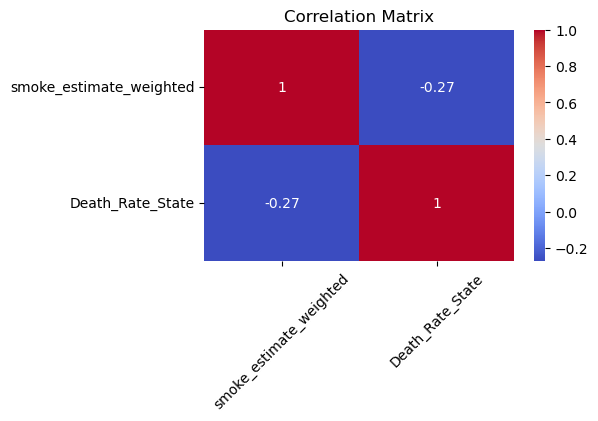

In [22]:
# Check Pearson correlation between smoke estimates and overall death rate
# Merge the dataframes
smoke_death_combined_df = pd.merge(fire_annual_smoke_estimates_df, healthcare_combined_df, left_on='Fire_Year', right_on='Year', how='inner')
# Calculate correlation
correlation = smoke_death_combined_df[['smoke_estimate_weighted', 'Death_Rate_State']].corr()
# Plot the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

### Marion County Analysis

#### Analysis 5
Check the correlation between premature deaths (by any cause) in Marion County and smoke estimates

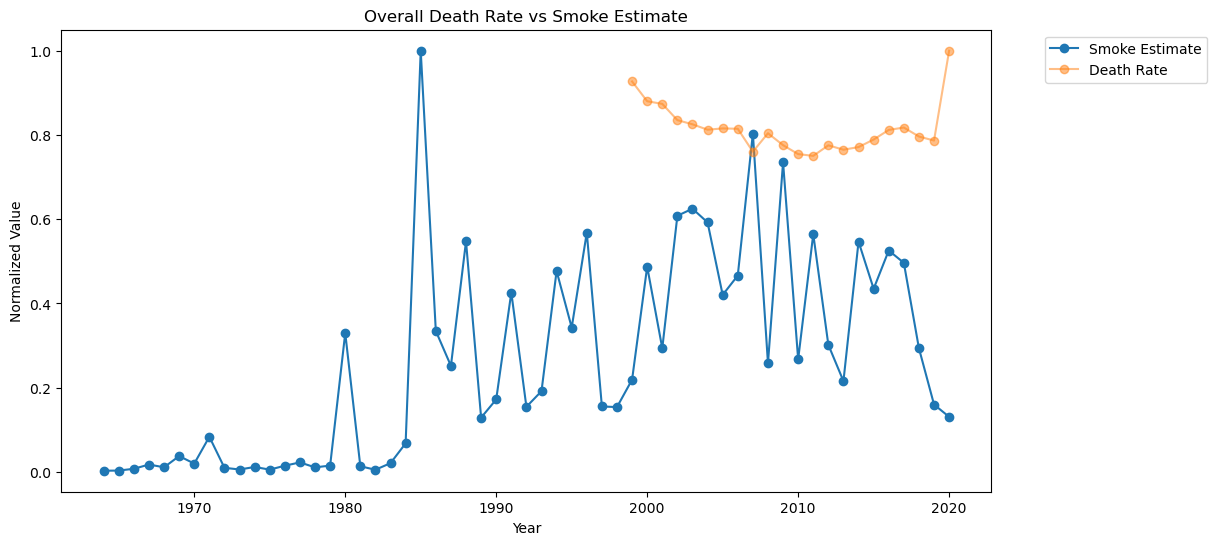

In [9]:
# Check the trend of smoke estimates and overall death rate in Marion County
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot asthma incidence rate
healthcare_death_df = healthcare_combined_df[['Year', 'Death_Rate']].dropna()
plt.plot(healthcare_death_df['Year'], 
         healthcare_death_df['Death_Rate']/max(healthcare_death_df['Death_Rate']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Overall Death Rate vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Death Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Nothing notable to be inferred from the trends themselves. 

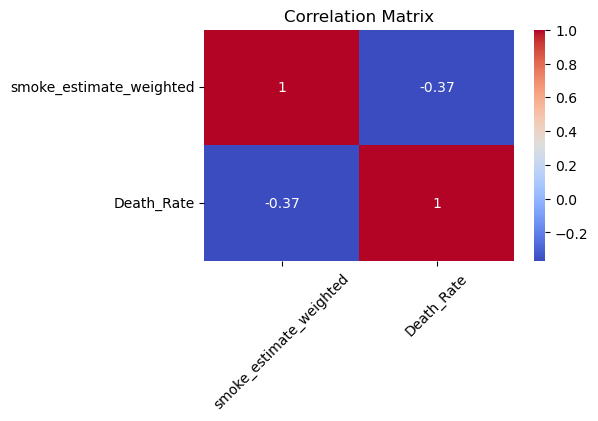

In [23]:
# Check Pearson correlation between smoke estimates and overall death rate in Marion County
# Merge the dataframes
smoke_death_combined_df = pd.merge(fire_annual_smoke_estimates_df, healthcare_combined_df, left_on='Fire_Year', right_on='Year', how='inner')
# Calculate correlation
correlation = smoke_death_combined_df[['smoke_estimate_weighted', 'Death_Rate']].corr()
# Plot the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

#### Analysis 6
Check the correlation between all respiratory illness-related trends in Marion County and smoke estimates.\
We do not have much data for Marion County respiratory illness as the data collection efforts have only recently started. Also we will be skipping on analyzing hospitalization trends and only focus on ED visits since Marion County has stopped collecting data for hospitalization trends. 

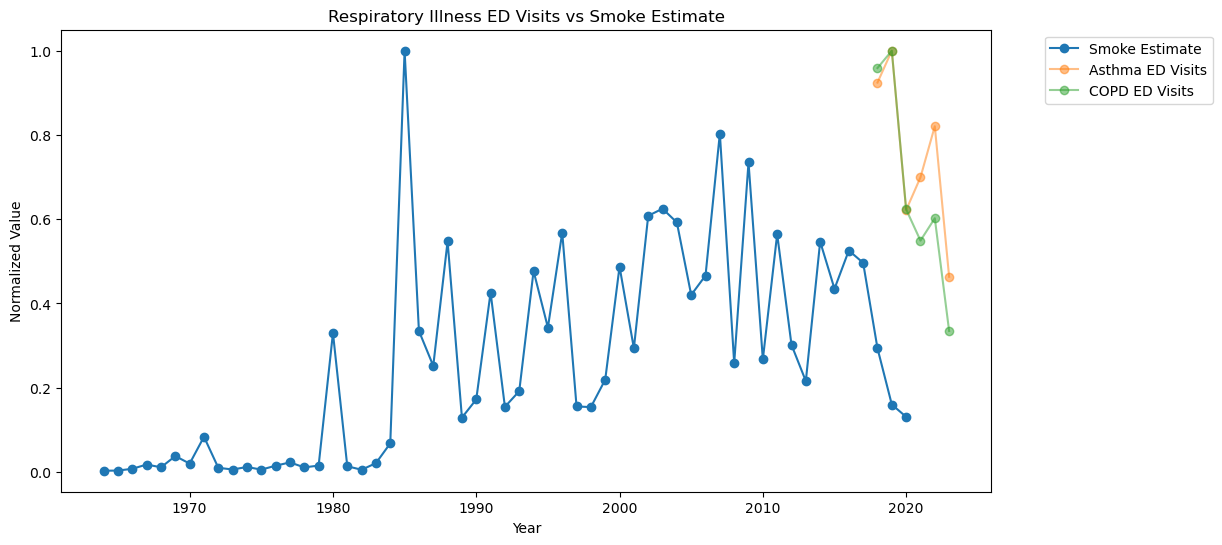

In [10]:
# Check the trend of smoke estimates and all respiratory illness-related rates in Marion County
# No need to focus on absolute values, just the trend
plt.figure(figsize=(12, 6))
# Plot smoke estimates
plt.plot(fire_annual_smoke_estimates_df['Fire_Year'], 
         fire_annual_smoke_estimates_df['smoke_estimate_weighted']/max(fire_annual_smoke_estimates_df['smoke_estimate_weighted']),
         marker='o', alpha=1.0)
# Plot asthma ED visits rate
healthcare_asthma_ed_df = healthcare_combined_df[['Year', 'Asthma_ED']].dropna()
plt.plot(healthcare_asthma_ed_df['Year'], 
         healthcare_asthma_ed_df['Asthma_ED']/max(healthcare_asthma_ed_df['Asthma_ED']), 
         marker='o', alpha=0.5)
# Plot COPD ED visits rate
healthcare_copd_ed_df = healthcare_combined_df[['Year', 'COPD_ED']].dropna()
plt.plot(healthcare_copd_ed_df['Year'], 
         healthcare_copd_ed_df['COPD_ED']/max(healthcare_copd_ed_df['COPD_ED']), 
         marker='o', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.title('Respiratory Illness ED Visits vs Smoke Estimate')
plt.legend(['Smoke Estimate', 'Asthma ED Visits', 'COPD ED Visits'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

There is almost no overlap between the date ranges of smoke estimates and Marion County's respiratory illness trends. 
Hence, we will be dropping any data related to Marion County, and focus on respiratory illness trends for the state of Indiana as a whole. 

**Assumption**

This means that we will be making the assumption that **the trends reflected in Indiana state as a whole are representative of those in Indiana state**.\
Until we get more data for Marion County, we cannot do our analysis on a lower level of granularity than state. 

This assumption is at least not too troublesome for our smoke estimates as Indianapolis is almost right at the center of Indiana, and the radius of Indiana state's convex hull is less than 200 miles. Thus our distance filter of 650 miles does not get violated.

## Time Series Forecasting of Respiratory Illness

In [93]:
#########
#
#    CONSTANTS
#
exog_cols = ['smoke_estimate_weighted']
SMOKE_ESTIMATES_FORECAST_PATH = 'final/forecasted_smoke_estimates.csv'
FORECAST_STEPS = 10

In [ ]:
#########
#
#    FUNCTIONS
#
def grid_search_VARMAX(*, data, endog_cols, exog_cols = exog_cols,
                       p_range = range(1, 6), q_range = range(1, 6),
                       train_size = 0.8, print_flag = True) -> tuple:
    """
    Perform grid search for VARMAX model to find the best p and q values.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the data.

    endog_cols : list
        The list of endogenous variables.

    exog_cols : list
        The list of exogenous variables.

    p_range : range
        The range of p values to search.
        Default is range(1, 6).

    q_range : range
        The range of q values to search.
        Default is range(1, 6).

    train_size : float
        The proportion of the data to use for training.
        Default is 0.8.

    print_flag : bool
        Whether to print the RMSE values.
        Default is True.
    Returns
    -------
    best_order : tuple
        The best order of the VARMAX model.
    """
    data_subset = data[endog_cols + exog_cols]
    # Split the data into training and testing sets
    # For time series data, the best practice is to split the data sequentially
    train_size = int(len(data_subset)*train_size)
    train_data = data_subset[:train_size]
    test_data = data_subset[train_size:]

    best_order = (0, 0)
    best_rmse = np.inf
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for p in p_range:
            for q in q_range:
                try:
                    model = VARMAX(train_data[endog_cols], exog = train_data[exog_cols], order = (p, q))
                    model_fit = model.fit(disp=False)
                    predictions = model_fit.forecast(steps = len(test_data), exog = test_data[exog_cols])
                    rmse_val = rmse(test_data[endog_cols], predictions)
                    # Multiple rmse values, one for each endogenous variable
                    # Thus, we take the mean of the rmse values
                    rmse_val = np.mean(rmse_val)
                    if print_flag:
                        print(f'p = {p}, q = {q}, RMSE = {rmse_val}')
                    if rmse_val < best_rmse:
                        best_rmse = rmse_val
                        best_order = (p, q)
                except Exception as e:
                    print(f'p = {p}, q = {q}, {e}')
    
    return best_order

In [83]:
def forecast(*, data, endog_cols, exog_cols = exog_cols, forecast_exog,
             order = (1, 1), forecast_steps = 5) -> pd.DataFrame:
    """
    Forecast using VARMAX model.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the data.

    endog_cols : list
        The list of endogenous variables.

    exog_cols : list
        The list of exogenous variables.
    
    forecast_exog : pd.DataFrame
        The exogenous data to use for forecasting.

    order : tuple
        The order of the VARMAX model.
        Default is (1, 1).

    forecast_steps : int
        The number of steps to forecast.
        Default is 5.

    Returns
    -------
    forecast_df : pd.DataFrame
        The forecasted values.
    """
    model = VARMAX(data[endog_cols], exog = data[exog_cols], order = order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps = forecast_steps, exog = forecast_exog[exog_cols][:forecast_steps])
    forecast_df = forecast.predicted_mean.join(forecast.conf_int())
    return forecast_df

In [95]:
forecasted_smoke_estimates_df = pd.read_csv(SMOKE_ESTIMATES_FORECAST_PATH)
forecasted_smoke_estimates_df = forecasted_smoke_estimates_df[:FORECAST_STEPS]
forecasted_smoke_estimates_df.head(2)

,smoke_estimate_weighted,Year
0,38.621092,2021
1,38.621092,2022


### Predict Asthma-related values

In [38]:
# Merge smoke estimates with asthma related data
asthma_related_df = healthcare_combined_df[['Year', 'Asthma_Incidence_Rate_State', 'Asthma_Death_Rate_State', 'Death_Rate_State']].dropna()

smoke_asthma_related_df = pd.merge(fire_annual_smoke_estimates_df, asthma_related_df, left_on='Fire_Year', right_on='Year', how='inner')
smoke_asthma_related_df = smoke_asthma_related_df.dropna()
smoke_asthma_related_df.head(2)

,Fire_Year,smoke_estimate_weighted,Year,Asthma_Incidence_Rate_State,Asthma_Death_Rate_State,Death_Rate_State
0,1999,27.668611,1999,946.534152,1.745294,401.7
1,2000,61.533159,2000,946.980314,1.595262,353.2


In [ ]:
asthma_endog_cols = ['Asthma_Incidence_Rate_State', 'Asthma_Death_Rate_State', 'Death_Rate_State']

In [50]:
# Get Best Parameters for Asthma
asthma_best_order = grid_search_VARMAX(data = smoke_asthma_related_df, endog_cols = asthma_endog_cols)

p = 1, q = 1, RMSE = 23.438787667954784
p = 1, q = 2, RMSE = 26.416233400653407
p = 1, q = 3, RMSE = 36.57655233340253
p = 1, q = 4, RMSE = 19.793271377495643
p = 1, q = 5, RMSE = 19.921327151462226
p = 2, q = 1, RMSE = 30.863275647210042
p = 2, q = 2, RMSE = 34.997136836514606
p = 2, q = 3, RMSE = 21.017183421166234
p = 2, q = 4, RMSE = 32.871831455897215
p = 2, q = 5, RMSE = 35.07668979654001
p = 3, q = 1, RMSE = 30.471592238312358
p = 3, q = 2, RMSE = 41.601089074922506
p = 3, q = 3, RMSE = 21.154591259224105
p = 3, q = 4, RMSE = 30.905408442423223
p = 3, q = 5, RMSE = 34.79654728761995
p = 4, q = 1, Matrix is not positive definite
p = 4, q = 2, Matrix is not positive definite
p = 4, q = 3, Matrix is not positive definite
p = 4, q = 4, Matrix is not positive definite
p = 4, q = 5, Matrix is not positive definite
p = 5, q = 1, Matrix is not positive definite
p = 5, q = 2, Matrix is not positive definite
p = 5, q = 3, Matrix is not positive definite
p = 5, q = 4, Matrix is not positiv

In [51]:
print(f'Best Order for Asthma: {asthma_best_order}')

Best Order for Asthma: (1, 4)


Use the time series data to predict the next 10 years. 

In [ ]:
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        asthma_forecast_df = forecast(data = smoke_asthma_related_df, endog_cols = asthma_endog_cols, order = asthma_best_order, 
                              forecast_steps = FORECAST_STEPS, forecast_exog=forecasted_smoke_estimates_df)

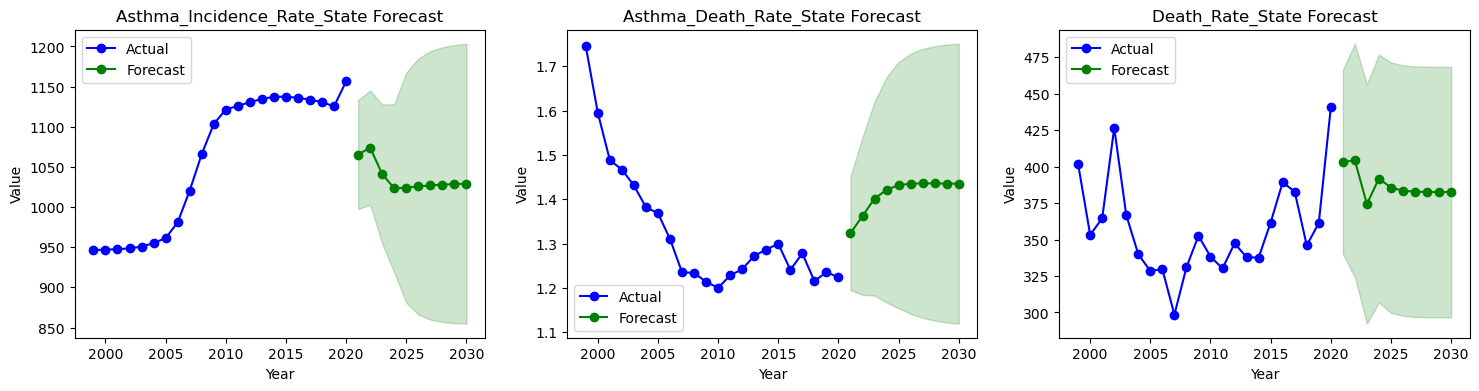

In [111]:
# Plot each forecasted variable of asthma with confidence intervals, in subplots
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 4)
for index, col in enumerate(asthma_endog_cols):
    ax[index].plot(smoke_asthma_related_df['Year'], smoke_asthma_related_df[col], marker='o', color='b')
    ax[index].plot(forecasted_smoke_estimates_df['Year'], asthma_forecast_df[col], marker='o', color='g')
    ax[index].fill_between(forecasted_smoke_estimates_df['Year'],
                            asthma_forecast_df[f'lower {col}'],
                            asthma_forecast_df[f'upper {col}'], color='g', alpha=0.2)
    ax[index].set_xlabel('Year')
    ax[index].set_ylabel('Value')
    ax[index].set_title(f'{col} Forecast')
    ax[index].legend(['Actual', 'Forecast'])

These trends seem generally reasonable. The Incidence and death rate forecasts are ignoring the last year in the data which saw a massive increase, which may not be prudent, but seems reasonable. 

### Predict COPD-related values

In [112]:
copd_related_df = healthcare_combined_df[['Year', 'COPD_Incidence_Rate_State', 'COPD_Death_Rate_State', 'Death_Rate_State']].dropna()

smoke_copd_related_df = pd.merge(fire_annual_smoke_estimates_df, copd_related_df, left_on='Fire_Year', right_on='Year', how='inner')
smoke_copd_related_df = smoke_copd_related_df.dropna()
smoke_copd_related_df.head(2)

,Fire_Year,smoke_estimate_weighted,Year,COPD_Incidence_Rate_State,COPD_Death_Rate_State,Death_Rate_State
0,1999,27.668611,1999,308.690479,55.230256,401.7
1,2000,61.533159,2000,315.439128,57.397441,353.2


In [113]:
copd_endog_cols = ['COPD_Incidence_Rate_State', 'COPD_Death_Rate_State', 'Death_Rate_State']

In [114]:
copd_best_order = grid_search_VARMAX(data = smoke_copd_related_df, endog_cols = copd_endog_cols)

p = 1, q = 1, RMSE = 25.94177994465871
p = 1, q = 2, RMSE = 28.125030861667316
p = 1, q = 3, RMSE = 23.526052705994022
p = 1, q = 4, RMSE = 27.900821138234665
p = 1, q = 5, RMSE = 24.36356952820924
p = 2, q = 1, RMSE = 33.52761092989644
p = 2, q = 2, RMSE = 27.095673243856478
p = 2, q = 3, RMSE = 28.761822355642412
p = 2, q = 4, RMSE = 28.262028757940694
p = 2, q = 5, RMSE = 32.72152786250627
p = 3, q = 1, RMSE = 32.74006649896158
p = 3, q = 2, RMSE = 56.40997716081671
p = 3, q = 3, RMSE = 32.86013300677059
p = 3, q = 4, RMSE = 28.701043869842266
p = 3, q = 5, RMSE = 33.70670388581546
p = 4, q = 1, Matrix is not positive definite
p = 4, q = 2, Matrix is not positive definite
p = 4, q = 3, Matrix is not positive definite
p = 4, q = 4, Matrix is not positive definite
p = 4, q = 5, Matrix is not positive definite
p = 5, q = 1, Matrix is not positive definite
p = 5, q = 2, Matrix is not positive definite
p = 5, q = 3, Matrix is not positive definite
p = 5, q = 4, Matrix is not positive def

In [115]:
print(f'Best Order for COPD: {copd_best_order}')

Best Order for COPD: (1, 3)


In [116]:
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        copd_forecast_df = forecast(data = smoke_copd_related_df, endog_cols = copd_endog_cols, order = copd_best_order, 
                              forecast_steps = FORECAST_STEPS, forecast_exog=forecasted_smoke_estimates_df)

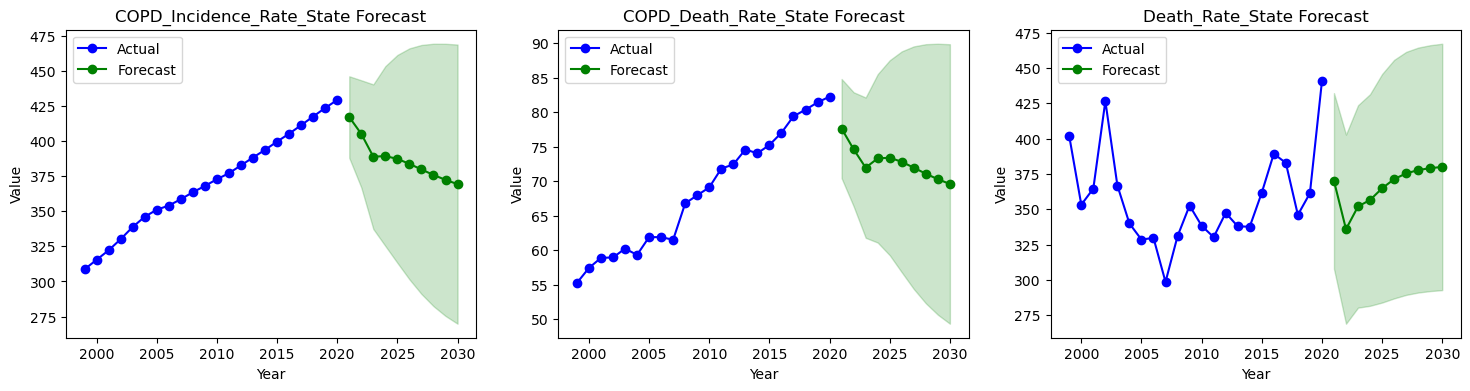

In [117]:
# Plot each forecasted variable of asthma with confidence intervals, in subplots
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 4)
for index, col in enumerate(copd_endog_cols):
    ax[index].plot(smoke_copd_related_df['Year'], smoke_copd_related_df[col], marker='o', color='b')
    ax[index].plot(forecasted_smoke_estimates_df['Year'], copd_forecast_df[col], marker='o', color='g')
    ax[index].fill_between(forecasted_smoke_estimates_df['Year'],
                            copd_forecast_df[f'lower {col}'],
                            copd_forecast_df[f'upper {col}'], color='g', alpha=0.2)
    ax[index].set_xlabel('Year')
    ax[index].set_ylabel('Value')
    ax[index].set_title(f'{col} Forecast')
    ax[index].legend(['Actual', 'Forecast'])

These trends are quite surprising. Despite the fact that COPD values have been steadily increasing over the years, the model predicts a steady decrease in both. It is unreasonable to attribute this anomalous trend to our smoke estimates as the forecasts predicted a constant trend for smoke.

Perhaps, the interaction with Death Rate among the variables for the forecasting seems to be confusing the model. So we will experiment with individual variables as well.

#### Predict COPD-related values without Death Rate

p = 5, q = 2, LU decomposition error.
Best Order for COPD Incidence Rate: (3, 4)


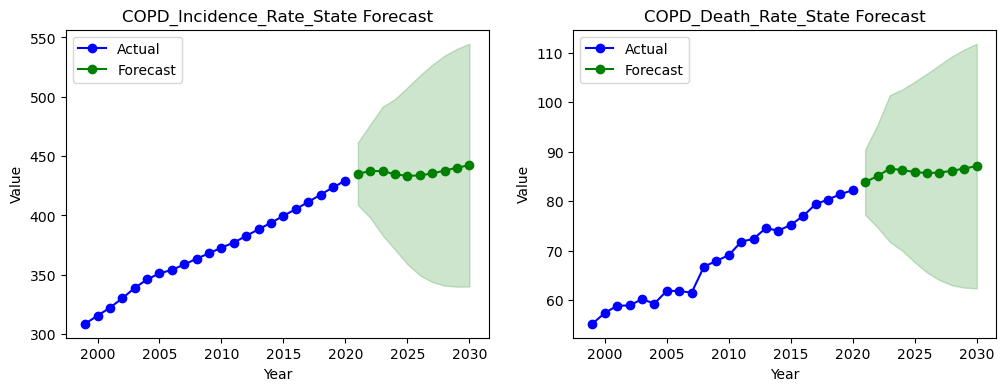

In [121]:
# Predict only 'COPD_Incidence_Rate_State' and 'COPD_Death_RATE_State' using VARIMAX
endog_copd_cols = ['COPD_Incidence_Rate_State', 'COPD_Death_Rate_State']
copd_wo_death_best_order = grid_search_VARMAX(data = smoke_copd_related_df, endog_cols = endog_copd_cols, exog_cols = exog_cols,
                                              print_flag=False)
print(f'Best Order for COPD Incidence Rate: {copd_wo_death_best_order}')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    copd_wo_death_forecast_df = forecast(data = smoke_copd_related_df, endog_cols = endog_copd_cols, order = copd_wo_death_best_order, 
                            forecast_steps = FORECAST_STEPS, forecast_exog=forecasted_smoke_estimates_df)

# Plot the forecasted COPD values with confidence intervals
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 4)

for index, col in enumerate(endog_copd_cols):
    ax[index].plot(smoke_copd_related_df['Year'], smoke_copd_related_df[col], marker='o', color='b')
    ax[index].plot(forecasted_smoke_estimates_df['Year'], copd_wo_death_forecast_df[col], marker='o', color='g')
    ax[index].fill_between(forecasted_smoke_estimates_df['Year'],
                            copd_wo_death_forecast_df[f'lower {col}'],
                            copd_wo_death_forecast_df[f'upper {col}'], color='g', alpha=0.2)
    ax[index].set_xlabel('Year')
    ax[index].set_ylabel('Value')
    ax[index].set_title(f'{col} Forecast')
    ax[index].legend(['Actual', 'Forecast'])